In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint
from catboost import CatBoostClassifier
from hyperopt import fmin, hp, tpe
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from geopy.geocoders import Nominatim

In [68]:
train_labels = pd.read_csv('train-labels.csv')
train_values = pd.read_csv('train-values.csv')
df_train = pd.merge(train_labels, train_values, on='id')
train_eda = df_train
df_test = pd.read_csv('test-values.csv')
print(len(df_train), len(df_test))

59400 14850


In [69]:
df_train['date'] = pd.to_datetime(df_train['date_recorded'])
df_train['day'] = df_train['date'].dt.day
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
df_train['weekday'] = df_train['date'].dt.weekday
df_train = df_train.drop('date_recorded', axis=1)

df_test['date'] = pd.to_datetime(df_test['date_recorded'])
df_test['day'] = df_test['date'].dt.day
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['weekday'] = df_test['date'].dt.weekday
df_test = df_test.drop('date_recorded', axis=1)

In [70]:
df_train = df_train.drop('scheme_name', axis=1)
df_test = df_test.drop('scheme_name', axis=1)

In [71]:
df_train = df_train.round({'latitude': 4, 'longitude': 4})
df_train['latitude_radians'] = np.radians(df_train['latitude'])
df_train['longitude_radians'] = np.radians(df_train['longitude'])
df_train['x'] = np.cos(df_train['latitude']) * np.cos(df_train['longitude'])
df_train['y'] = np.cos(df_train['latitude']) * np.sin(df_train['longitude'])
df_train['z'] = np.sin(df_train['latitude'])

df_test = df_test.round({'latitude': 4, 'longitude': 4})
df_test['latitude_radians'] = np.radians(df_test['latitude'])
df_test['longitude_radians'] = np.radians(df_test['longitude'])
df_test['x'] = np.cos(df_test['latitude']) * np.cos(df_test['longitude'])
df_test['y'] = np.cos(df_test['latitude']) * np.sin(df_test['longitude'])
df_test['z'] = np.sin(df_test['latitude'])

In [72]:
kmeans = KMeans(5)
clusters_train = kmeans.fit_predict(df_train[['latitude', 'longitude']])
df_train['clusters'] = kmeans.predict(df_train[['latitude', 'longitude']])

kmeans = KMeans(5)
clusters_test = kmeans.fit_predict(df_test[['latitude', 'longitude']])
df_test['clusters'] = kmeans.predict(df_test[['latitude', 'longitude']])

In [73]:
df_train.loc[df_train['population'] <= 15000, 'population'] = 10000
df_test.loc[df_test['population'] <= 15000, 'population'] = 10000

df_train.loc[df_train['longitude'] < 10, 'longitude'] = 30
df_test.loc[df_test['longitude'] < 10, 'longitude'] = 30

df_train.loc[df_train['latitude'] == 0, 'latitude'] = -1
df_test.loc[df_test['latitude'] == 0, 'latitude'] = -1

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

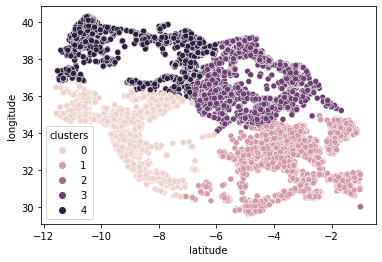

In [63]:
sns.scatterplot(x='latitude', y='longitude', data=df_test, 
                hue='clusters')

In [64]:
geolocator = Nominatim(user_agent='myGeocoder')
location = geolocator.reverse("-9.8563, 34.9381")
print(location)

query_list_train = []
for idx, row in df_train.iterrows():
    query_train = f"{row['latitude']}, {row['longitude']}"
    query_list_train.append(query_train)

    
query_list_test = []
for idx, row in df_test.iterrows():
    query_test = f"{row['latitude']}, {row['longitude']}"
    query_list_test.append(query_test)

Mavanga, Ludewa, Njombe, Southern Highlands Zone, Tanzania


In [66]:
state_list_train = []
city_list_train = []
for query in query_list_train:
    location = geolocator.reverse(query)
    state_list_train.append(location.raw.get('address').get('state'))
    city_list_train.append(location.raw.get('address').get('city_district'))
    
df_train['state'] = state_list_train
df_train['city_district'] = city_list_train


state_list_test = []
city_list_test = []
for query in query_list_test:
    location = geolocator.reverse(query)
    state_list_test.append(location.raw.get('address').get('state'))
    city_list_test.append(location.raw.get('address').get('city_district'))
    
df_test['state'] = state_list_test
df_test['city_district'] = city_list_test

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=-6.8638&lon=39.3279&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [74]:
y = df_train.status_group
df = pd.concat([df_train, df_test]).set_index('id')
df.drop('status_group', axis=1, inplace=True)
train_ids = df_train.id.values
test_ids = df_test.id.values

In [75]:
aux_df = pd.DataFrame(index=df.columns, data={'uniques': df.nunique(),
                                                    'type': df.dtypes,
                                                    'nulls': df.isnull().sum(),
                                                    'nulls%': df.isnull().sum()/len(df) * 100
                                                    })
cat_vars = aux_df[aux_df['type'] == 'object'].index
num_vars = aux_df[aux_df['type'] != 'object'].index

In [76]:
df_train[cat_vars] = df_train[cat_vars].fillna('none')
# df_train[num_vars] = df_train[num_vars].fillna(0)

df_test[cat_vars] = df_test[cat_vars].fillna('none')
# df_test[num_vars] = df_test[num_vars].fillna(0)

In [77]:
model = CatBoostClassifier(
                           iterations=1000,
                           depth=9,
                           learning_rate=0.07,
                           loss_function='MultiClass', 
                           eval_metric='MultiClass', 
                           nan_mode="Min",
                           cat_features=cat_vars)

X = df_train.drop('status_group', axis=1)
y = df_train['status_group']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

model.fit(X_train, y_train)
preds = model.predict(X_valid)

print(accuracy_score(y_valid, preds))

0:	learn: 1.0420364	total: 809ms	remaining: 13m 27s
1:	learn: 0.9933088	total: 1.52s	remaining: 12m 40s
2:	learn: 0.9508835	total: 2.19s	remaining: 12m 9s
3:	learn: 0.9139695	total: 2.89s	remaining: 11m 58s
4:	learn: 0.8833986	total: 3.51s	remaining: 11m 38s
5:	learn: 0.8547748	total: 4.11s	remaining: 11m 20s
6:	learn: 0.8294123	total: 4.73s	remaining: 11m 11s
7:	learn: 0.8075327	total: 5.42s	remaining: 11m 11s
8:	learn: 0.7882438	total: 6.05s	remaining: 11m 5s
9:	learn: 0.7699966	total: 6.7s	remaining: 11m 2s
10:	learn: 0.7538662	total: 7.34s	remaining: 11m
11:	learn: 0.7379607	total: 7.89s	remaining: 10m 49s
12:	learn: 0.7248142	total: 8.69s	remaining: 10m 59s
13:	learn: 0.7112150	total: 9.36s	remaining: 10m 59s
14:	learn: 0.6995700	total: 10.1s	remaining: 11m 1s
15:	learn: 0.6888362	total: 10.7s	remaining: 10m 59s
16:	learn: 0.6787511	total: 11.3s	remaining: 10m 56s
17:	learn: 0.6699070	total: 11.9s	remaining: 10m 50s
18:	learn: 0.6611779	total: 12.7s	remaining: 10m 54s
19:	learn: 0

<AxesSubplot:xlabel='Importances', ylabel='Feature Id'>

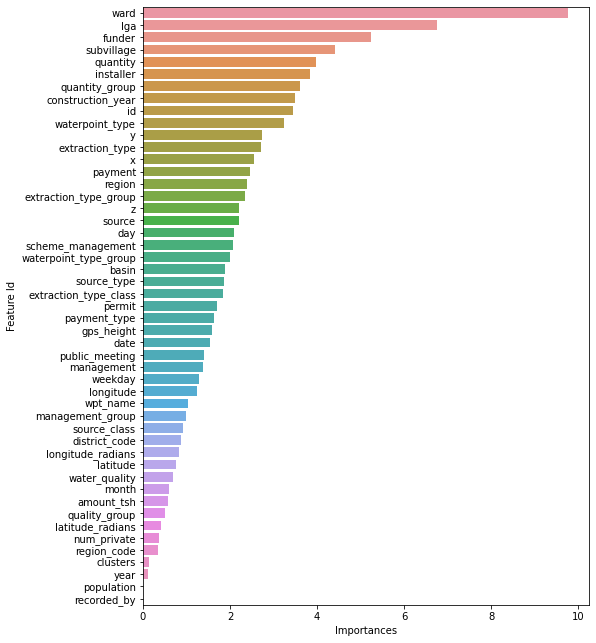

In [78]:
plt.figure(figsize=(8, 11))
importances = model.get_feature_importance(prettified=True)
sns.barplot(x='Importances', y='Feature Id', data=importances)

In [79]:
preds = model.predict(df_test)
predict_df = pd.DataFrame({'id': test_ids,
                           'status_group': [i[0] for i in preds]}).set_index('id')
print(predict_df['status_group'].value_counts())
predict_df.to_csv('submission_catboost_v4.csv')

functional                 9072
non functional             5277
functional needs repair     501
Name: status_group, dtype: int64


In [24]:
# Optimize between 10 and 1000 iterations and depth between 2 and 12

search_space = {'iterations': hp.quniform('iterations', 10, 1000, 10),
                'depth': hp.quniform('depth', 2, 12, 1),
                'lr': hp.uniform('lr', 0.01, 1)
               }

X = df_train.drop('status_group', axis=1)
y = df_train['status_group']

def optimal_function(search_space):
    
    nfolds = 5
    skf = StratifiedKFold(n_splits=nfolds, shuffle=True)
    acc = []
    
    for train_index, valid_index in skf.split(X, y):
        
        X_train, X_valid = X.iloc[train_index].copy(), X.iloc[valid_index].copy()
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model = CatBoostClassifier(iterations=search_space['iterations'],
                                   depth=search_space['depth'], 
                                   learning_rate=search_space['lr'],
                                   loss_function='MultiClass',
                                   od_type='Iter')

        model.fit(X_train, y_train, cat_vars, logging_level='Silent')
        predictions = model.predict(X_valid)
        accuracy = accuracy_score(y_valid, predictions.squeeze())
        acc.append(accuracy)
    
    mean_acc = sum(acc) / nfolds
    return -1 * mean_acc

best = fmin(fn=optimal_function, space=search_space, algo=tpe.suggest, max_evals=100)
print(best)

  1%|▍                                     | 1/100 [3:25:52<339:40:57, 12352.10s/trial, best loss: -0.7991077441077441]


KeyboardInterrupt: 

In [25]:
# Grid Search

grid = {'iterations': np.arange(10, 1000, 10),
        'max_depth': np.arange(2, 13, 1),
        'learning_rate': np.arange(0.01, 1, 0.01)
       }

X = df_train.drop('status_group', axis=1)
y = df_train['status_group']

model = CatBoostClassifier(cat_features=cat_vars, 
                           nan_mode='Min',
                           loss_function='MultiClass', 
                           eval_metric='MultiClass', 
                           logging_level='Silent')

grid_search = GridSearchCV(estimator=model, param_grid=grid, 
                           scoring='accuracy', cv=5)

grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

KeyboardInterrupt: 

In [12]:
# Random Search

grid = {
        'max_depth': np.arange(2, 13, 1),
        'learning_rate': np.linspace(0.01, 0.2, 5)
       }

X = df_train.drop('status_group', axis=1)
y = df_train['status_group']

model = CatBoostClassifier(cat_features=cat_vars, 
                           nan_mode='Min',
                           loss_function='MultiClass', 
                           eval_metric='MultiClass', 
                           logging_level='Silent')

grid_search = GridSearchCV(estimator=model, param_grid=grid, 
                           scoring='accuracy', cv=5, verbose=1)

grid_search.fit(X, y)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


KeyboardInterrupt: 

In [ ]:
preds = model.predict(df_test)
predict_df = pd.DataFrame({'id': test_ids,
                           'status_group': [i[0] for i in preds]}).set_index('id')
print(predict_df['status_group'].value_counts())
predict_df.to_csv('submission_catboost_v2.csv')